In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
from tqdm import tqdm_notebook
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)

from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import sin,log,pow
import lightgbm as lgb
import datetime
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import multiprocessing as mp
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])
        
from itertools import groupby
from operator import itemgetter

def get_info_consecutive(data,max_len=24):
    return([x for x in [(next(g), sum(1 for i in g)+1) for k, g in groupby(enumerate(data), key=itemgetter(1))] if x[1]>max_len])

def get_position_consecutive(infol):
    pos = []
    for x in infol:
        pos += np.arange(start=x[0][0]+1,stop=x[0][0]+x[1]).tolist()
    return(pos)

def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()


../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv


In [2]:
def importer(align=False,drop_consecutive=False):
    train = pd.read_csv(f'{path}train.csv')
    train['timestamp'] = pd.to_datetime(train['timestamp'],format='%Y-%m-%d %H:%M:%S')
    train['meter_reading'] = np.log1p(train['meter_reading'])
    weather_train = pd.read_csv(f'{path_new}new_weather_train.csv')
    weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'],format='%Y-%m-%d %H:%M:%S')

    building_metadata = pd.read_csv(f'{path}building_metadata.csv')
    building_metadata = building_metadata[['site_id','building_id','primary_use']]

#     weather_train['country'] = weather_train['site_id'].map(country)
    timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
    weather_train['time_diff'] = weather_train['site_id'].map(timediff)
    weather_train['time_diff'] = pd.to_timedelta(weather_train['time_diff'],'h')
    if align:
        weather_train['timestamp'] = weather_train['timestamp'] - weather_train['time_diff']
        
    # target_train_df['hour'] = target_train_df['hour'] + target_train_df['time_diff']
    # target_train_df.loc[target_train_df['hour']>23, 'hour'] = target_train_df[target_train_df['hour']>23]['hour'] - 24

    train = train.merge(building_metadata, left_on = "building_id", right_on = "building_id", how = "left")
    country = {0:'UnitedStates',1:'England',2:'UnitedStates',3:'UnitedStates',4:'UnitedStates',
           5:'England',6:'UnitedStates',7:'Canada',8:'UnitedStates',9:'UnitedStates',10:'UnitedStates',
           11:'Canada',12:'Ireland',13:'UnitedStates',14:'UnitedStates',15:'UnitedStates'}
    city = {0:'Jacksonville',1:'London',2:'Phoenix',3:'Philadelphia',4:'San Francisco',
           5:'Loughborough',6:'Philadelphia',7:'Montreal',8:'Jacksonville',9:'San Antonio',10:'Las Vegas',
           11:'Montreal',12:'Dublin',13:'Minneapolis',14:'Philadelphia',15:'Pittsburgh'} 
    train['country'] = train['site_id'].map(country)
    train['city'] = train['site_id'].map(city)

    train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")

    if drop_consecutive:
        train_df = pd.DataFrame({'building_id':train.building_id,'meter':train.meter,'meter_reading':train.meter_reading})

        train_df['dummy'] = np.arange(train_df.shape[0])
        position = []
        for building_id in tqdm_notebook(range(1449)):
            train_gb = train_df[train_df['building_id'] == building_id].groupby("meter")

            for meter, tmp_df in train_gb:
                data = tmp_df['meter_reading'].values

                infol = get_info_consecutive(data=data,max_len=24)

                position += tmp_df.iloc[get_position_consecutive(infol),:]['dummy'].tolist()
        position = np.sort(position).tolist()
        train.drop(position,axis=0,inplace=True)
    return(train)

In [3]:
train_align = importer(align = True,drop_consecutive=False)
train_not_align = importer(align = False,drop_consecutive=False)

In [4]:
numeric_var = ['air_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed',
              'relative_humidity','heat_index','wind_chill','wind_load','temp_diff']

In [5]:
def correlater(df_init,feature):
    groups = df_init[['meter', 'site_id']].drop_duplicates().values.tolist()
    groups = list(tuple(e) for e in groups)  # make it immutable
    correlations_init = dict()

    weather_features = [feature]

    # get correlations, spearman - to catch monotonic but less linear dependencies, that pearson allows
    for (m, sid) in groups:
        idx = (df_init.meter == m) & (df_init.site_id == sid)
        corrs = df_init.loc[idx, weather_features].corrwith(df_init.loc[idx, 'meter_reading'], method='spearman')
        correlations_init[(m, sid)] = dict(corrs)

    # create dataframe from it
    df_corr_init = pd.DataFrame(correlations_init).T.sort_index()
    df_corr_init.index = df_corr_init.index.set_names(['meter', 'site_id'])
    df_corr_init = df_corr_init.unstack(level=[0])
    return(df_corr_init)

def color_values(val):
    if val < 0:
        color = 'red'
    elif val == 0:
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color


In [6]:
for feat in tqdm_notebook(numeric_var):
    mat_cor_not_align = correlater(train_not_align,feat)
    mat_cor_align = correlater(train_align,feat)
    
    display((mat_cor_align - mat_cor_not_align).groupby(level=[0]).mean().style.format("{:.2%}").applymap(color_values).highlight_null())


LETS CHECK FOR HOLIDAY AND METER CONSUMPTION

In [7]:
import holidays
state = {'Jacksonville':'FL','London':None,'Phoenix':'AZ','Philadelphia':'PA','San Francisco':'CA',
 'Loughborough':None,'Philadelphia':'PA','Montreal':'QC','Jacksonville':'FL',
 'San Antonio':'TX','Las Vegas':'NV','Montreal':'QC','Dublin':None,'Minneapolis':'MN','Philadelphia':'PA',
 'Pittsburgh':'PA'}

city_country_dic = {'Jacksonville':'UnitedStates','London':'England','Phoenix':'UnitedStates','Philadelphia':'UnitedStates',
                    'San Francisco':'UnitedStates','Loughborough':'England','Philadelphia':'UnitedStates',
                    'Montreal':'Canada','Jacksonville':'UnitedStates','San Antonio':'UnitedStates',
                    'Las Vegas':'UnitedStates','Montreal':'Canada',
                    'Dublin':'Ireland','Minneapolis':'UnitedStates','Philadelphia':'UnitedStates','Pittsburgh':'UnitedStates'}

train_align['Holiday'] = True
for (city,abbr) in tqdm_notebook(state.items()):
    
    if city_country_dic[city] == 'UnitedStates':
        holiday = holidays.CountryHoliday(city_country_dic[city],state=abbr)
    else:
        holiday = holidays.CountryHoliday(city_country_dic[city],prov=abbr)
        
    train_align.loc[train_align.city==city,'Holiday'] = [x in holiday for x in train_align.loc[train_align.city==city,'timestamp']]

In [8]:
graph_df = train_align.copy()
free_space(['train_align','train_not_align'])

graph_df['meter_reading']=np.expm1(graph_df['meter_reading'])
graph_df['data'] = graph_df['timestamp']
graph_df['data'] = graph_df['data'].dt.date
graph_df['year'] = graph_df['timestamp']
graph_df['year'] = graph_df['year'].dt.year
graph_df['weekday'] = graph_df['timestamp']
graph_df['weekday'] = graph_df['weekday'].dt.weekday


In [9]:
graph_info = graph_df.groupby(['site_id','primary_use','weekday','data','Holiday'])['meter_reading'].sum().reset_index()

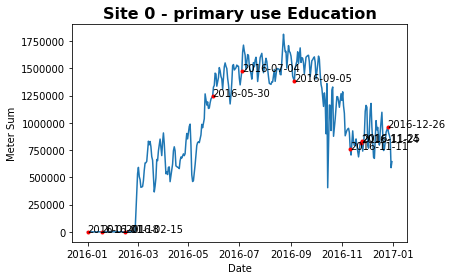

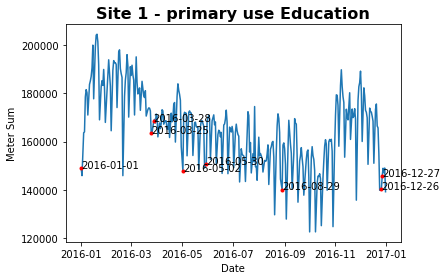

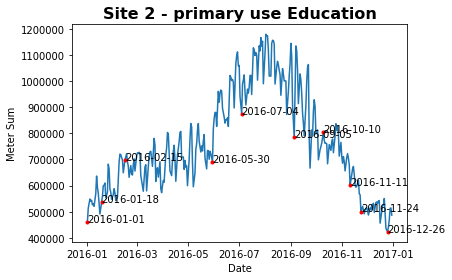

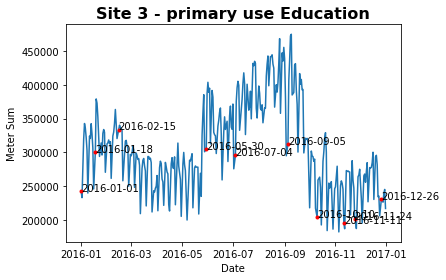

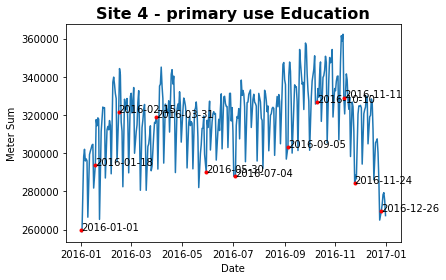

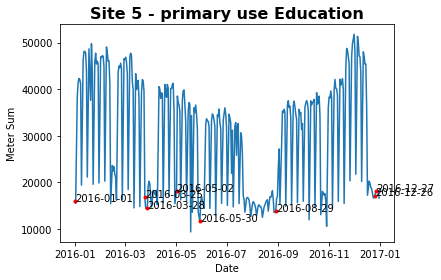

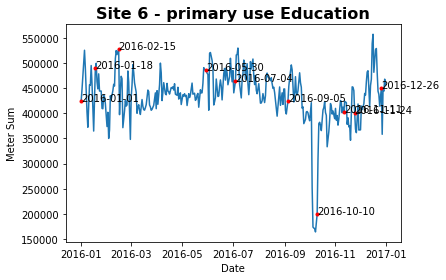

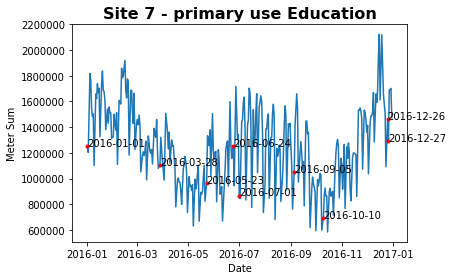

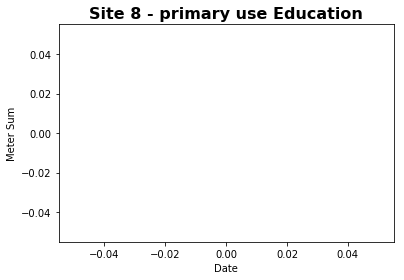

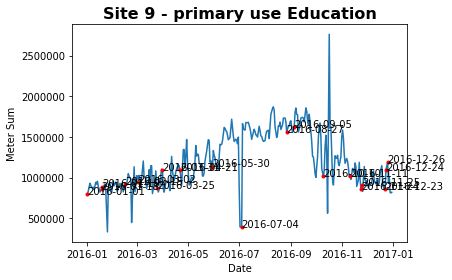

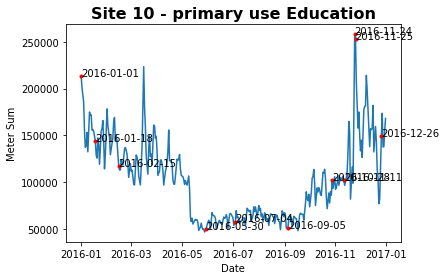

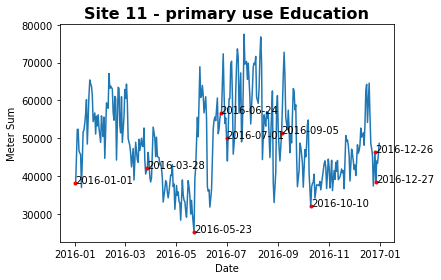

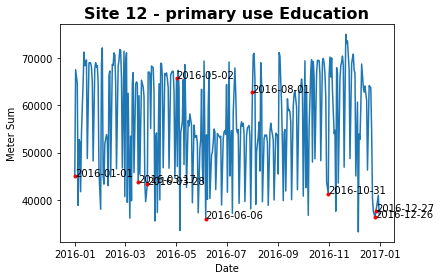

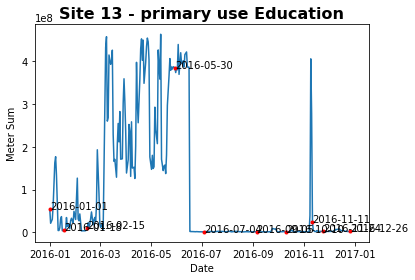

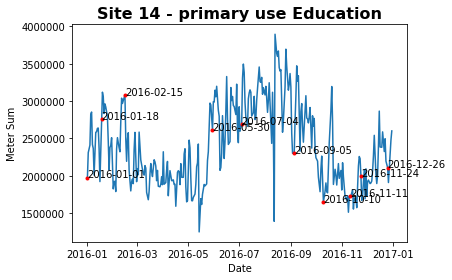

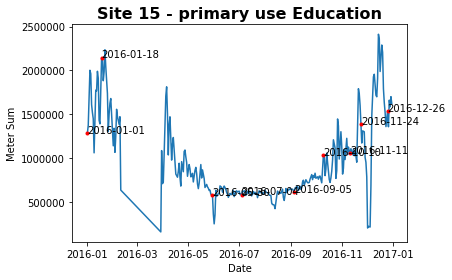

In [10]:
for site in np.sort(graph_info['site_id'].unique()):
    mask = (graph_info['site_id']==site) & (graph_info['weekday']<=5) & (graph_info['primary_use']=='Education')
    sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'],ci =None)
    for index, row in graph_info.loc[mask & (graph_info.loc[mask,'Holiday']==True)].iterrows():
        plt.plot([row['data']], [row['meter_reading']], marker='o', markersize=3, color="red")
        plt.annotate(row['data'],(row['data'],row['meter_reading']))
    plt.title("Site {} - primary use {}".format(site,'Education'),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()


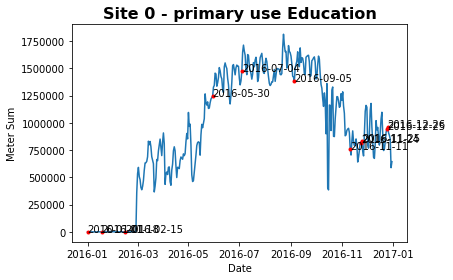

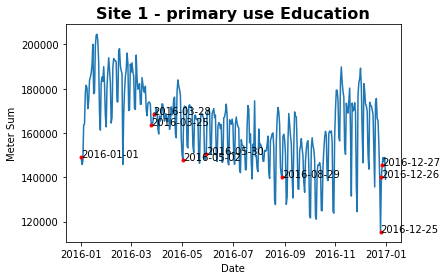

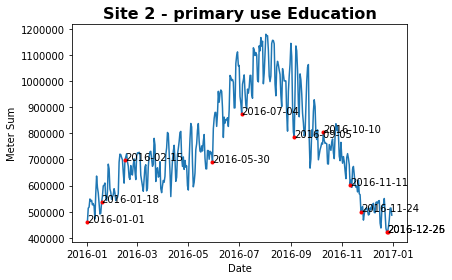

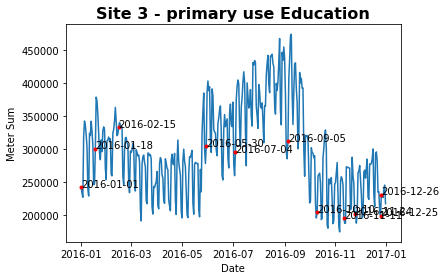

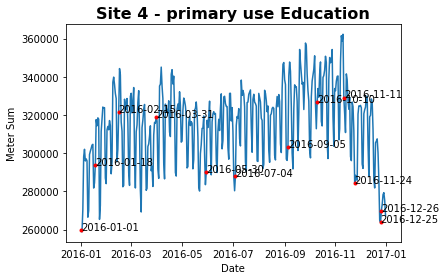

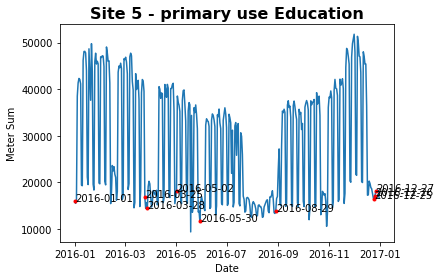

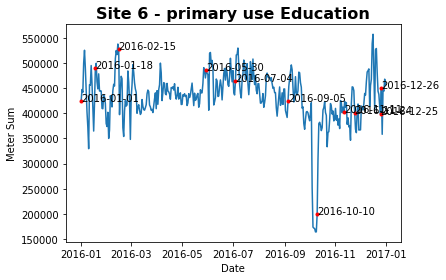

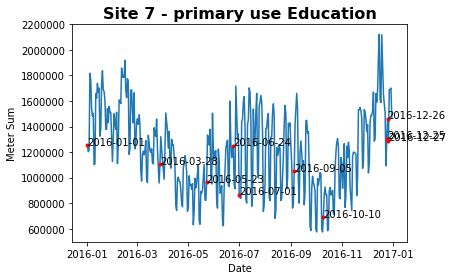

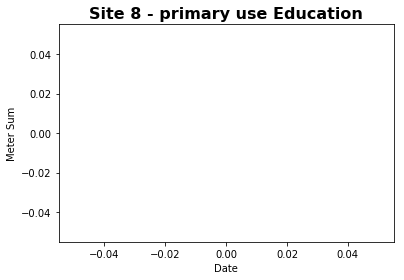

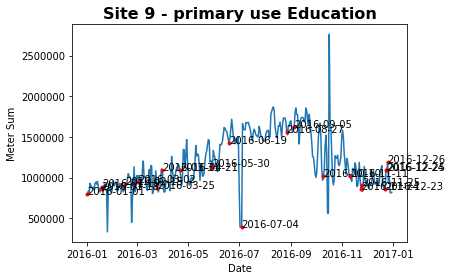

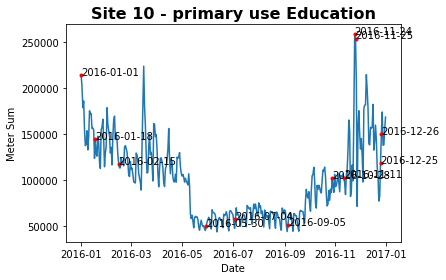

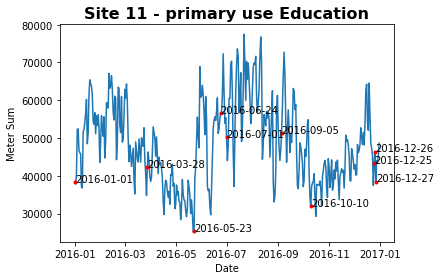

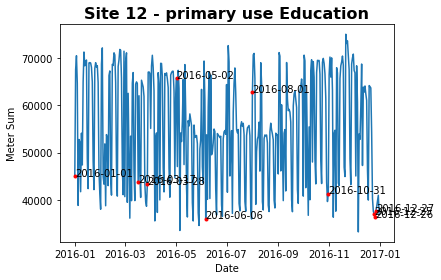

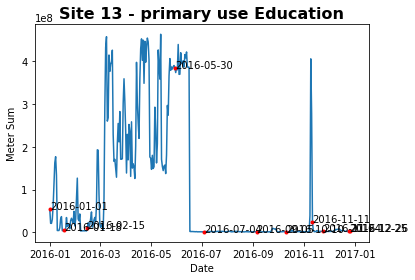

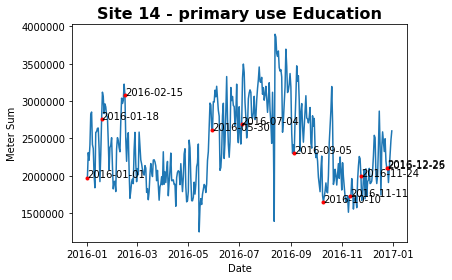

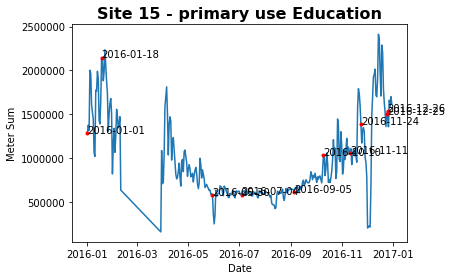

In [11]:
for site in np.sort(graph_info['site_id'].unique()):
    mask = (graph_info['site_id']==site) & (graph_info['primary_use']=='Education')
    sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'],ci =None)
    for index, row in graph_info.loc[mask & (graph_info.loc[mask,'Holiday']==True)].iterrows():
        plt.plot([row['data']], [row['meter_reading']], marker='o', markersize=3, color="red")
        plt.annotate(row['data'],(row['data'],row['meter_reading']))
    plt.title("Site {} - primary use {}".format(site,'Education'),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()


In [12]:
graph_info.loc[mask & (graph_info.loc[mask,'Holiday']==True)]

,site_id,primary_use,weekday,data,Holiday,meter_reading
36558,15,Education,0,2016-01-18,True,2.147179e+06
36570,15,Education,0,2016-05-30,True,5.747954e+05
36575,15,Education,0,2016-07-04,True,5.857513e+05
36584,15,Education,0,2016-09-05,True,6.127118e+05
36589,15,Education,0,2016-10-10,True,1.037564e+06
36600,15,Education,0,2016-12-26,True,1.538716e+06
36732,15,Education,3,2016-11-24,True,1.386710e+06
36738,15,Education,4,2016-01-01,True,1.289186e+06
36776,15,Education,4,2016-11-11,True,1.060770e+06
36874,15,Education,6,2016-12-25,True,1.498366e+06


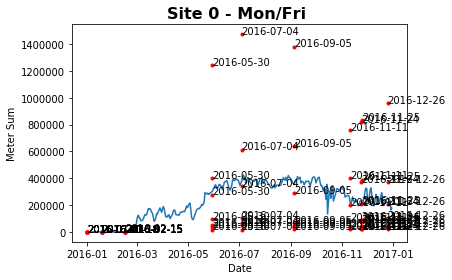

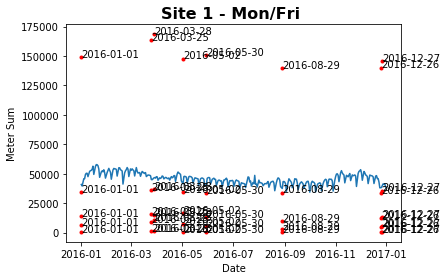

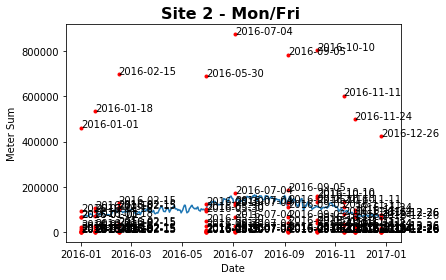

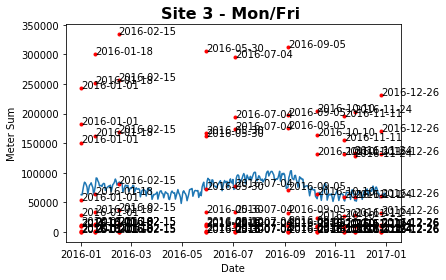

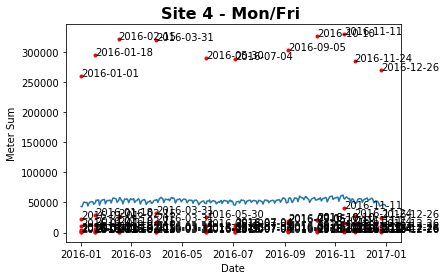

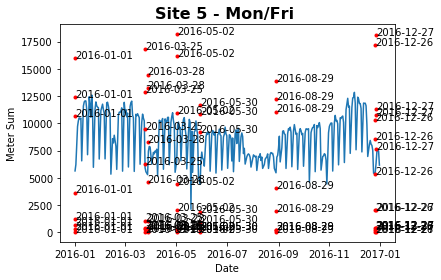

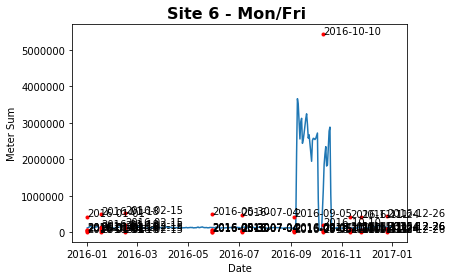

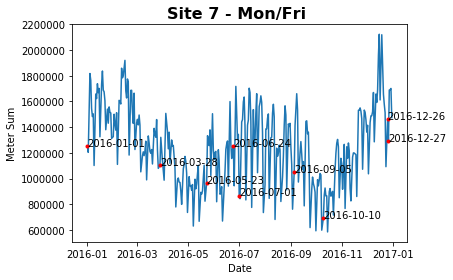

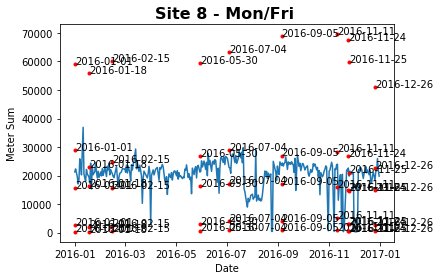

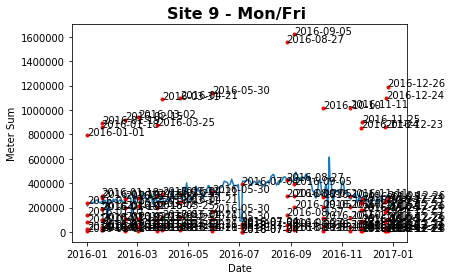

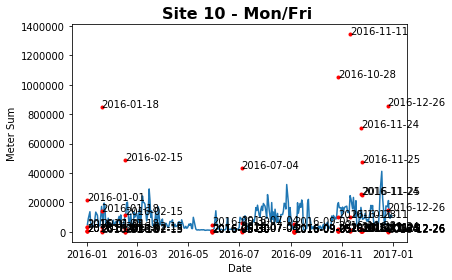

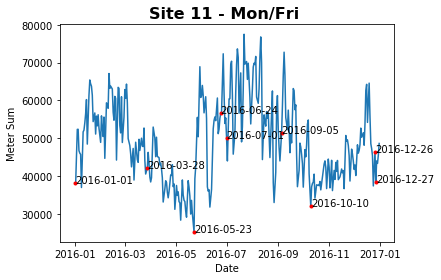

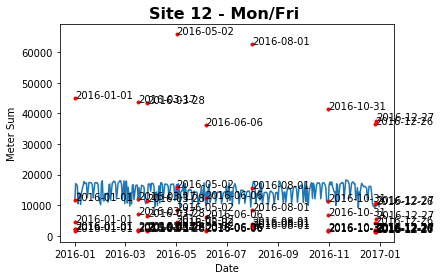

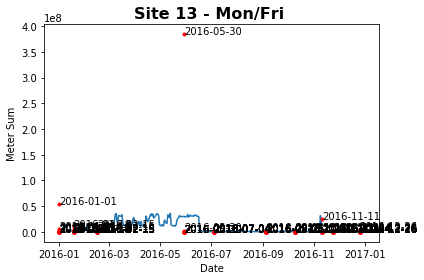

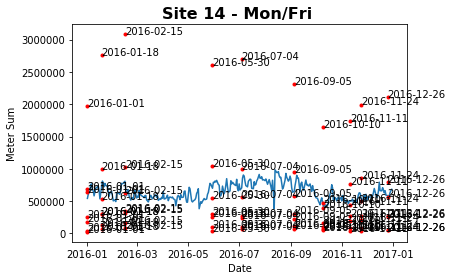

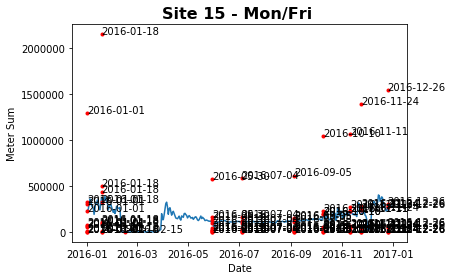

In [13]:
for site in np.sort(graph_info['site_id'].unique()):
    mask = (graph_info['site_id']==site) & (graph_info['weekday']<=5)
    sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'],ci =None)
#     plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'],linestyle='solid')

    for index, row in graph_info.loc[mask & (graph_info.loc[mask,'Holiday']==True)].iterrows():
        plt.plot([row['data']], [row['meter_reading']], marker='o', markersize=3, color="red")
        plt.annotate(row['data'],(row['data'],row['meter_reading']))
    plt.title("Site {} - Mon/Fri ".format(site,),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()
